# **Smoker Detection Dataset**

#Description
The dataset contains 1120 images divided equally into two classes, where 560 images are of Smoking (smokers) and remaining 560 images belong to
 NotSmoking  (non-smokers) class. The dataset is curated by scanning through various search engines by entering multiple keywords that include cigarette
  smoking, smoker, person, coughing, taking inhaler, person on the phone, drinking water etc. We tried to consider versatile images in both classes for
  creating a certain degree of inter-class confusion in order to better train the model. For instance, Smoking class contains images of smokers from multiple
  angles and various gestures. Moreover, the images in NotSmoking class consists of images of non-smokers with slightly similar gestures as that of smoking
  images such as people drinking water, using inhaler, holding the mobile phone, coughing etc. The dataset can be used by the prospective researchers to
  propose deep learning algorithms for automated detection and screening of smoker towards ensuring the green environment and performing surveillance in
  smart cities. All images in the dataset are preprocessed and resized to a resolution of 250×250. We considered 80% of the data for training and validation
  purposes and 20% for the testing.

  


In [1]:
!pip install unrar

In [2]:
from google.colab import files

uploaded = files.upload()


Saving Smoker_detection.zip to Smoker_detection.zip


In [3]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.2 MB/s eta 0:00:00


In [6]:
from google.colab import drive
import zipfile
zip_file_path = '/content/Smoker_detection.zip'

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [24]:
Train_path = '/content/Smoker_detection/Training/Training'
Test_Path = '/content/Smoker_detection/Testing/Testing'
Valid_path = '/content/Smoker_detection/Validation/Validation'

In [25]:
training_ds_path = os.listdir(Train_path)
testing_ds_path = os.listdir(Test_Path)
validation_ds_path =  os.listdir(Valid_path)

In [26]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

In [29]:
def plot_random_images(folder_path, rows=4, cols=4):

    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    #print(image_files)

    # Randomly select images to plot
    selected_images = random.sample(image_files, min(rows * cols, len(image_files)))

    # Create a subplot with the specified number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

    # Plot each selected image
    for i in range(rows):
        for j in range(cols):
            if i * cols + j < len(selected_images):
                img_path = os.path.join(folder_path, selected_images[i * cols + j])
                img = mpimg.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

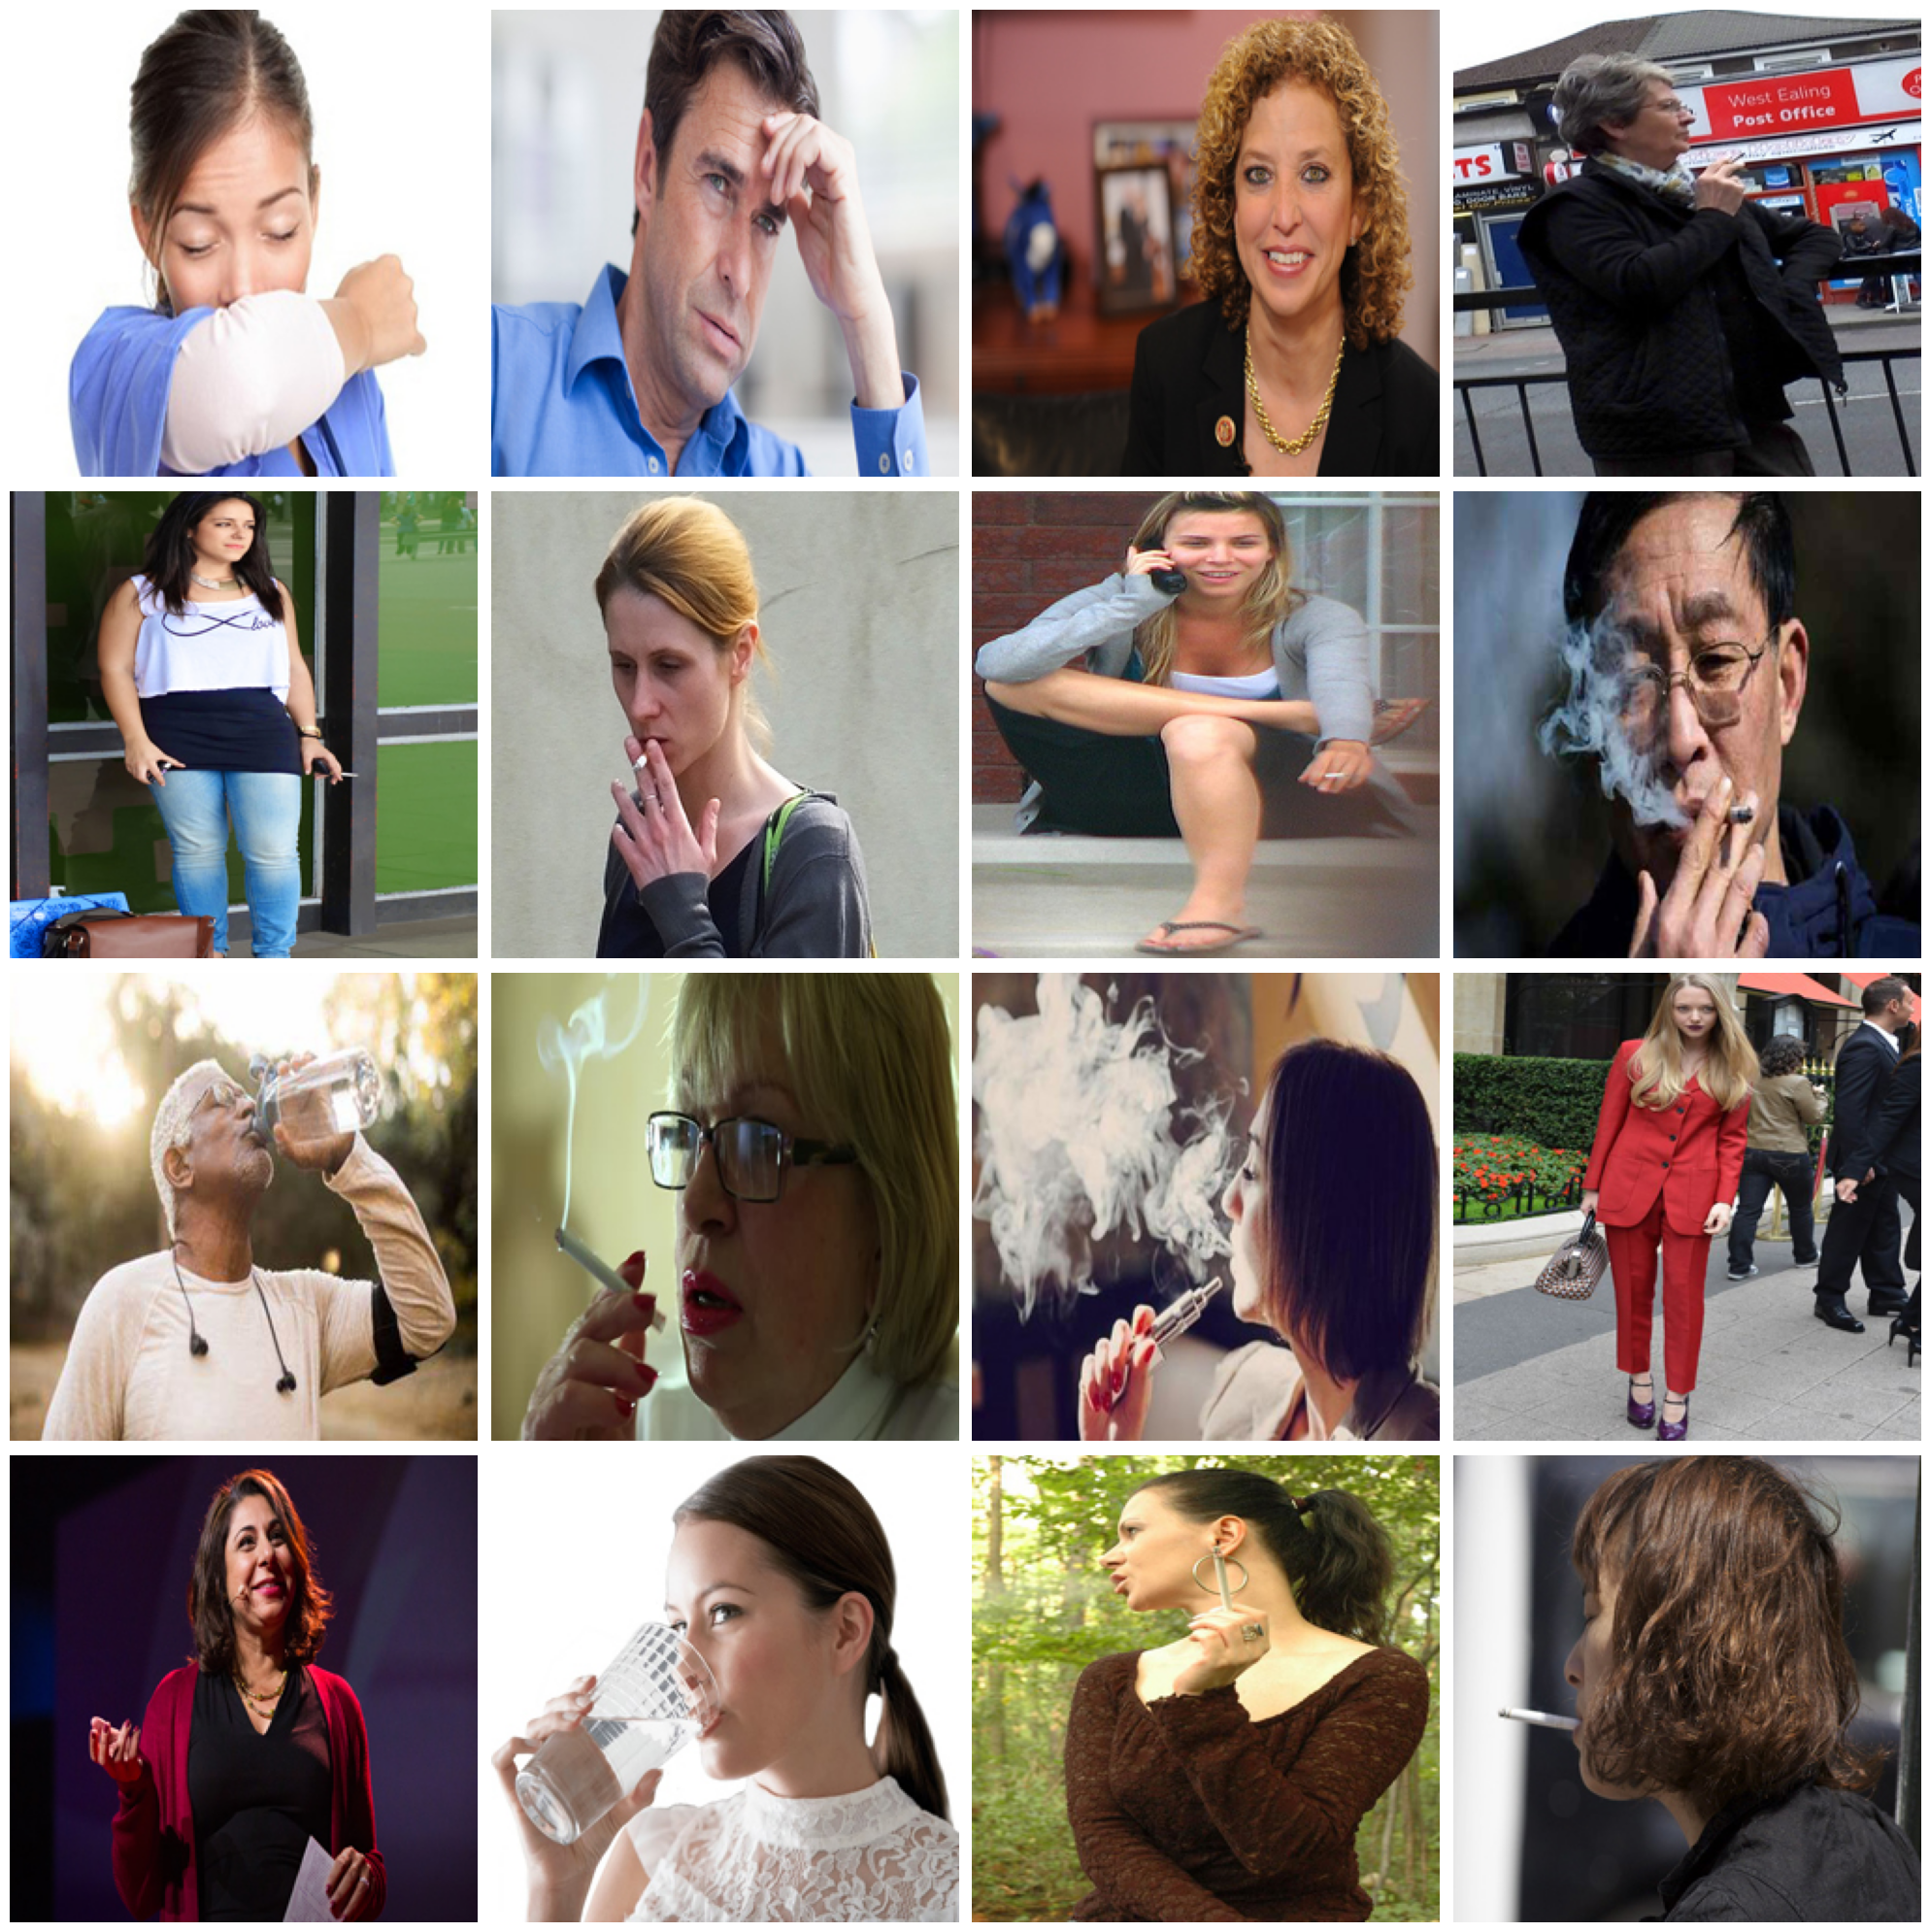

In [30]:
plot_random_images(Train_path)

In [31]:

# Set the path to your dataset
dataset_path = '/content/Smoker_detection/Training/Training'

# Get the list of image filenames
image_filenames = os.listdir(dataset_path)
#print(image_filenames)

# Extract labels from filenames

labels = [1 if 'notsmoking' in filename.lower() else 0 for filename in image_filenames]


# Create a DataFrame for easier handling
import pandas as pd
df = pd.DataFrame({'filename': image_filenames, 'label': labels})

In [32]:
df.head()

filename  label
0     smoking_0376.jpg      0
1     smoking_0011.jpg      0
2     smoking_0203.jpg      0
3     smoking_0042.jpg      0
4  notsmoking_0339.jpg      1

In [33]:
df['label'].value_counts()

0    358
1    358
Name: label, dtype: int64

In [34]:
df.dtypes

filename    object
label        int64
dtype: object

In [35]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Define image dimensions and batch size
img_height, img_width = 150, 150
batch_size = 32

# Convert the label column to string
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

In [36]:
# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [37]:
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 572 validated image filenames belonging to 2 classes.


In [38]:
validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    directory=dataset_path,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 144 validated image filenames belonging to 2 classes.


## Model 1 - CNN (4 Convolution and Max pooling Layers)

In [39]:
from tensorflow.keras import models, layers

# Build a modified CNN model
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Additional Convolutional Layer
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before the dense layers
model2.add(layers.Flatten())

# Additional Dense Layer
model2.add(layers.Dense(256, activation='relu'))

# Dropout layer to reduce overfitting
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(1, activation='sigmoid'))

In [40]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
epochs = 5
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
18/18 [==============================] - 38s 2s/step - loss: 0.7006 - accuracy: 0.5490 - val_loss: 0.6450 - val_accuracy: 0.6667
Epoch 2/5
18/18 [==============================] - 35s 2s/step - loss: 0.5890 - accuracy: 0.7185 - val_loss: 0.5918 - val_accuracy: 0.6806
Epoch 3/5
18/18 [==============================] - 36s 2s/step - loss: 0.5770 - accuracy: 0.7150 - val_loss: 0.6107 - val_accuracy: 0.6944
Epoch 4/5
18/18 [==============================] - 36s 2s/step - loss: 0.5491 - accuracy: 0.7273 - val_loss: 0.5715 - val_accuracy: 0.7292
Epoch 5/5
18/18 [==============================] - 37s 2s/step - loss: 0.5595 - accuracy: 0.7325 - val_loss: 0.5714 - val_accuracy: 0.6944


In [43]:
# Evaluate the model
loss1, accuracy1 = model2.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy1 * 100:.2f}%")

5/5 [==============================] - 2s 400ms/step - loss: 0.5714 - accuracy: 0.6944
Validation accuracy: 69.44%


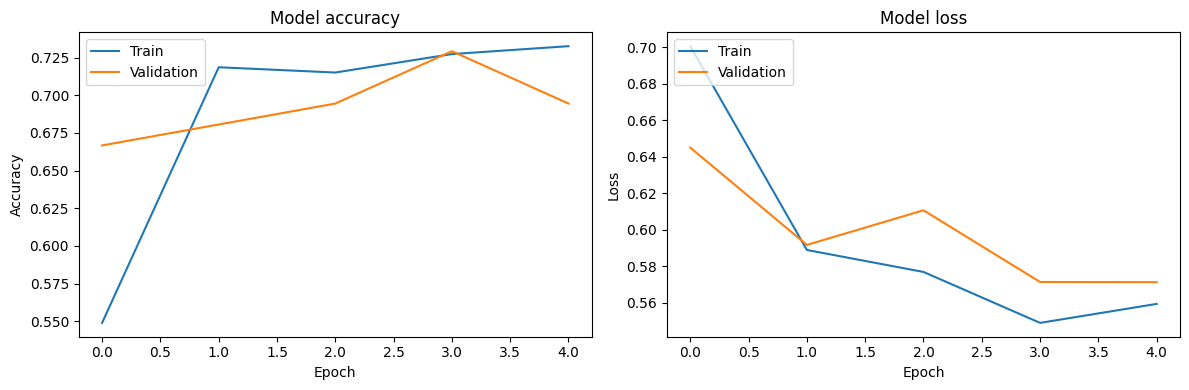

In [44]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [45]:
# Set the path to your test dataset
test_dataset_path = '/content/Smoker_detection/Testing/Testing'

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Assuming it's a binary classification task
)

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Found 224 images belonging to 2 classes.
7/7 [==============================] - 3s 465ms/step - loss: 1.0527 - accuracy: 0.3080
Test accuracy: 30.80%


In [46]:
# Set the path to your test dataset
test_dataset_path = '/content/Smoker_detection/Testing/Testing'

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model2.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class = 1 if prediction > 0.5 else 0

# Print the result
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 143ms/step
Predicted class: 0


1/1 [==============================] - 0s 37ms/step


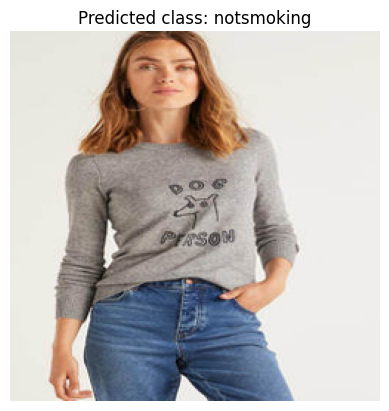

1/1 [==============================] - 0s 50ms/step


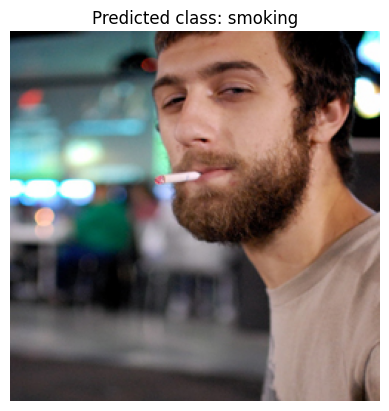

In [47]:
test_dataset_path = '/content/Smoker_detection/Testing/Testing'

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model2.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model2.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

## Model 2 - ResNet

In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

# Load the pre-trained ResNet50 model (excluding the top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False

# Build a new model on top of ResNet50
model3 = models.Sequential()

model3.add(resnet_model)

# Flatten the output before the dense layers
model3.add(layers.Flatten())

# Additional Dense Layer
model3.add(layers.Dense(256, activation='relu'))

# Dropout layer to reduce overfitting
model3.add(layers.Dropout(0.5))

model3.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [49]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
epochs = 5
history = model3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
18/18 [==============================] - 75s 4s/step - loss: 1.9037 - accuracy: 0.5507 - val_loss: 1.0494 - val_accuracy: 0.5000
Epoch 2/5
18/18 [==============================] - 69s 4s/step - loss: 0.9118 - accuracy: 0.5437 - val_loss: 0.8065 - val_accuracy: 0.5000
Epoch 3/5
18/18 [==============================] - 78s 4s/step - loss: 0.6941 - accuracy: 0.5315 - val_loss: 0.6883 - val_accuracy: 0.5069
Epoch 4/5
18/18 [==============================] - 68s 4s/step - loss: 0.6896 - accuracy: 0.5542 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 5/5
18/18 [==============================] - 69s 4s/step - loss: 0.6863 - accuracy: 0.5524 - val_loss: 0.6841 - val_accuracy: 0.5347


In [51]:
# Evaluate the model
loss2, accuracy2 = model3.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy2 * 100:.2f}%")

5/5 [==============================] - 13s 3s/step - loss: 0.6841 - accuracy: 0.5347
Validation accuracy: 53.47%


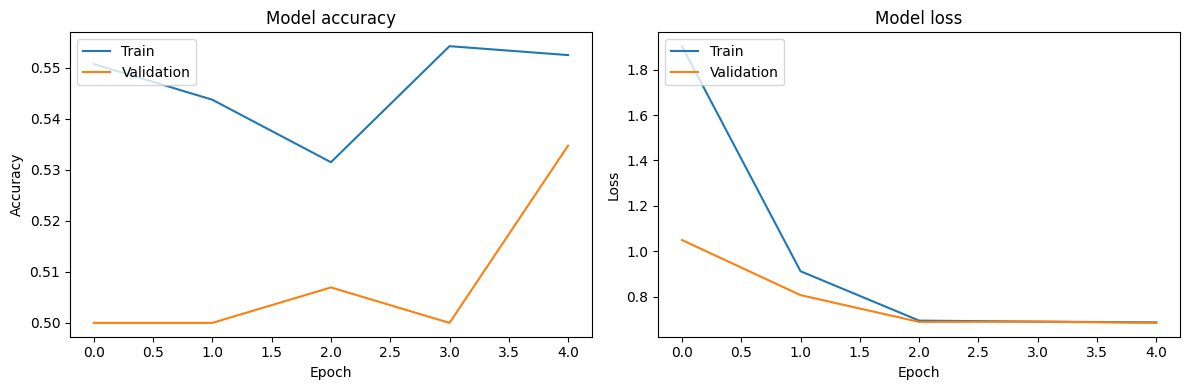

In [52]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [54]:
# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 20s 3s/step - loss: 0.7116 - accuracy: 0.4062
Test accuracy: 40.62%


In [55]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model3.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class = 1 if prediction > 0.5 else 0

# Print the result
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 1s 1s/step
Predicted class: 1


1/1 [==============================] - 0s 128ms/step


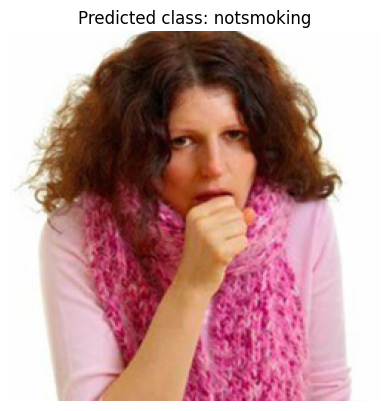

1/1 [==============================] - 0s 125ms/step


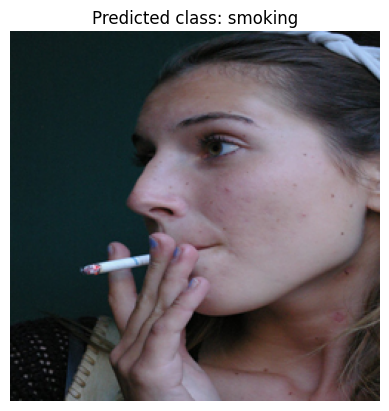

In [56]:
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model3.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model3.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

## Model 3 - VGG with batch normalization

In [57]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load the pre-trained VGG16 model (excluding the top layer)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

# Build a new model on top of VGG16
model5 = models.Sequential()

model5.add(vgg_model)

# Flatten the output before the dense layers
model5.add(layers.Flatten())

# Additional Dense Layers with Batch Normalization
model5.add(layers.Dense(512, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))

model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))

# Output layer
model5.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [58]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
epochs = 5
history = model5.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
18/18 [==============================] - 192s 11s/step - loss: 0.8610 - accuracy: 0.6643 - val_loss: 0.4831 - val_accuracy: 0.7847
Epoch 2/5
18/18 [==============================] - 183s 10s/step - loss: 0.5094 - accuracy: 0.7570 - val_loss: 0.5827 - val_accuracy: 0.7569
Epoch 3/5
18/18 [==============================] - 190s 11s/step - loss: 0.4498 - accuracy: 0.8147 - val_loss: 0.6477 - val_accuracy: 0.7500
Epoch 4/5
18/18 [==============================] - 189s 11s/step - loss: 0.4212 - accuracy: 0.8287 - val_loss: 0.5269 - val_accuracy: 0.7986
Epoch 5/5
18/18 [==============================] - 189s 11s/step - loss: 0.3891 - accuracy: 0.8217 - val_loss: 0.7159 - val_accuracy: 0.7500


In [60]:
# Evaluate the model
loss3, accuracy3 = model5.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy3 * 100:.2f}%")

5/5 [==============================] - 37s 7s/step - loss: 0.7159 - accuracy: 0.7500
Validation accuracy: 75.00%


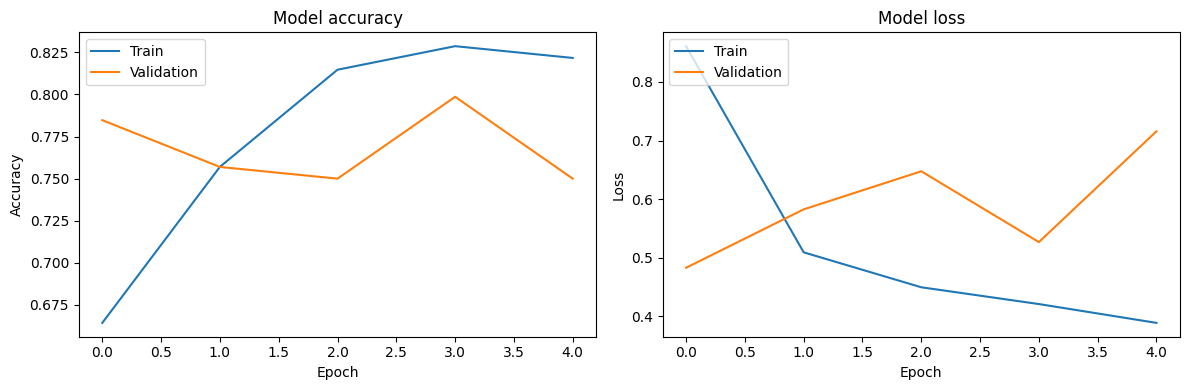

In [61]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [72]:
# Evaluate the model on the test set
test_loss, test_accuracy = model5.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 56s 8s/step - loss: 3.3095 - accuracy: 0.2009
Test accuracy: 20.09%


In [63]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model5.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class = 1 if prediction > 0.5 else 0

# Print the result
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 456ms/step
Predicted class: 0


1/1 [==============================] - 0s 262ms/step


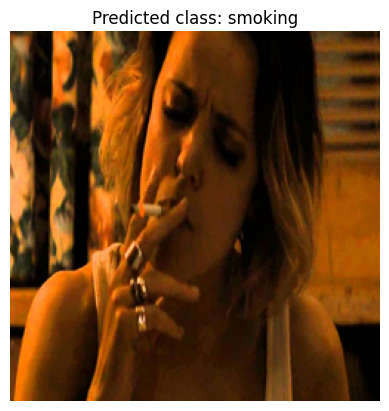

1/1 [==============================] - 0s 264ms/step


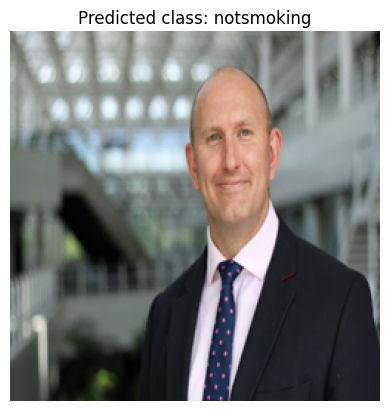

In [64]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model5.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model5.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

## Model 4 - Alexnet

In [65]:
from tensorflow.keras import models, layers

# Build AlexNet-like model
model6 = models.Sequential()

# Layer 1
model6.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(img_height, img_width, 3)))
model6.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Layer 2
model6.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model6.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Layer 3
model6.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Layer 4
model6.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Layer 5
model6.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model6.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Flatten the output before the dense layers
model6.add(layers.Flatten())

# Dense layers
model6.add(layers.Dense(4096, activation='relu'))
model6.add(layers.Dropout(0.5))

model6.add(layers.Dense(4096, activation='relu'))
model6.add(layers.Dropout(0.5))

model6.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
epochs = 5
history = model6.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
18/18 [==============================] - 51s 3s/step - loss: 0.7842 - accuracy: 0.5035 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 2/5
18/18 [==============================] - 48s 3s/step - loss: 0.6943 - accuracy: 0.5262 - val_loss: 0.6850 - val_accuracy: 0.5139
Epoch 3/5
18/18 [==============================] - 49s 3s/step - loss: 0.6867 - accuracy: 0.5524 - val_loss: 0.6816 - val_accuracy: 0.5208
Epoch 4/5
18/18 [==============================] - 48s 3s/step - loss: 0.6779 - accuracy: 0.5612 - val_loss: 0.6865 - val_accuracy: 0.5069
Epoch 5/5
18/18 [==============================] - 49s 3s/step - loss: 0.6443 - accuracy: 0.5962 - val_loss: 0.6512 - val_accuracy: 0.5694


In [67]:
# Evaluate the model
loss4, accuracy4 = model6.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy4 * 100:.2f}%")

5/5 [==============================] - 3s 451ms/step - loss: 0.6512 - accuracy: 0.5694
Validation accuracy: 56.94%


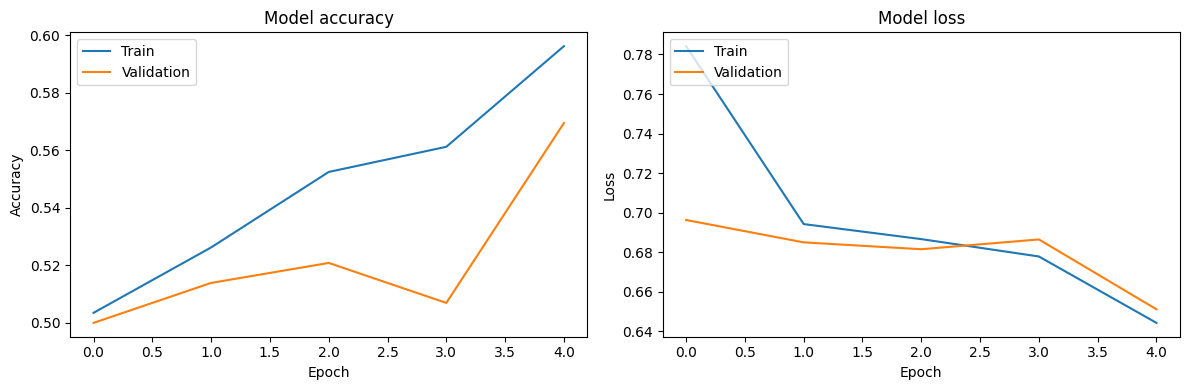

In [68]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [69]:
# Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 4s 546ms/step - loss: 0.8920 - accuracy: 0.3482
Test accuracy: 34.82%


In [70]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model6.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class = 1 if prediction > 0.5 else 0

# Print the result
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 216ms/step
Predicted class: 0


1/1 [==============================] - 0s 105ms/step


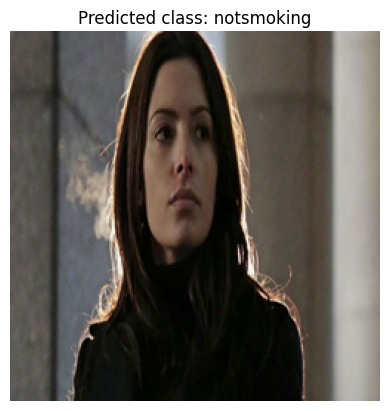

1/1 [==============================] - 0s 55ms/step


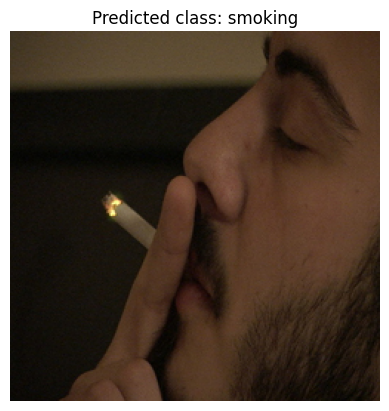

In [71]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model6.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model6.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='notsmoking' if prediction > 0.5 else 'smoking'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

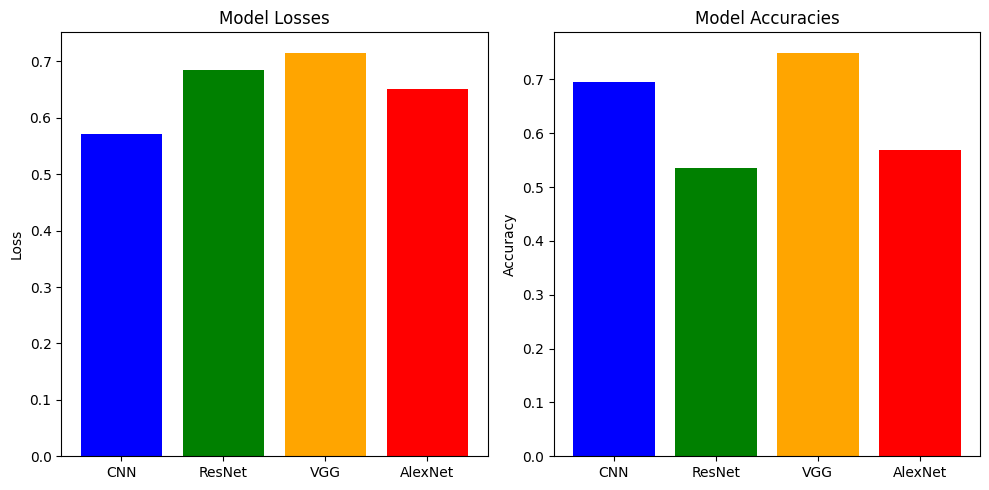

In [75]:
import matplotlib.pyplot as plt

# Example data (replace with your actual values)
models = ['CNN', 'ResNet', 'VGG', 'AlexNet']
losses = [loss1, loss2, loss3, loss4]  # Replace with your actual losses
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4]  # Replace with your actual accuracies

# Plotting Losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, losses, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Losses')
plt.ylabel('Loss')

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')

# Show the plot
plt.tight_layout()
plt.show()